# Thoughts and todo's
* Make widget for selecting output step!
    * [Check out itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)
    * [Check out Panel](https://panel.pyviz.org/index.html)
* [Better volume rendering](https://docs.pyvista.org/examples/02-plot/volume.html#sphx-glr-examples-02-plot-volume-py)
* Prettier plots
    * Figure out better camera position and lightings!
    * Different color grid labels?
* Why does pv.Plotter sometimes show nothing while pv.BackgroundPlotter does?
* Update grid with time?

# Ideally
* Widgets to select scalars
    * Callback function that transposes and ravels scalar values at timesteps
    * Adds these new values to to mesh

In [1]:
import pyvista as pv
import numpy as np
import xarray as xr
from JulesD3D.utils import quickDF
from JulesD3D.processNetCDF import fixMeshGrid, addVectorSum, addDepth, makeVelocity, addUnderlayerCoords
from JulesD3D.plotPyVista import makeBottomSurface, makeStructuredGridDepth, easyTimeFormat
from JulesD3D.utils import ncFilepicker
from cmocean.cm import deep, deep_r
from IPython.display import Markdown as md
# import matplotlib.pyplot as plt
from os import path
# from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox
# from itkwidgets import view
# import panel as pn
# pn.extension('vtk')

In [2]:
# pv.set_plot_theme("document") # for white background

## Open Delft3D results file

In [3]:
# folder = '/Volumes/Seagate Expansion Drive/ThesisResults/Current'
folder = '/Users/julesblom/ThesisResults/MultiTest'

nc_filename = ncFilepicker(folder)

In [4]:
nc_filename

Select(description='NetCDF file:', layout=Layout(height='120px', width='100%'), options=('/Users/julesblom/The…

In [5]:
basename = path.basename(nc_filename.value)
plot_title, _ = path.splitext(basename)
plot_title

'trim-36km_200m_W60ChannelRun02_compressed'

In [6]:
trim = xr.open_dataset(nc_filename.value) # Open with xarray : DataSet : A collection of DataArrays

In [7]:
# trim.keys()

In [8]:
if 'velocity' not in trim:
    trim = fixMeshGrid(trim, trim.XZ.values, trim.YZ.values, mystery_flag=True)
#     trim = makeBottomStress(trim)
    trim = addDepth(trim)
    trim = makeVelocity(trim)
    trim = addUnderlayerCoords(trim)
else:
    print("DataSet is preprocessed, 'velocity' is already in DataSet")

------ Fixing mesh grid, assuming a uniform grid ------
x_gridstep:	 200.0 m
y_gridstep:	 200.0 m
width:		 26000.0 m
length:		 36200.0 m
132 x 182 grid


In [9]:
# Reorder velocity dims to match x, y, z
velocity = trim.velocity.transpose('time', 'M', 'N', 'KMAXOUT_RESTR')
velocity.dims

('time', 'M', 'N', 'KMAXOUT_RESTR')

In [10]:
density = trim.RHO.transpose('time', 'M', 'N', 'KMAXOUT_RESTR')
density.dims

('time', 'M', 'N', 'KMAXOUT_RESTR')

In [11]:
concentration = trim.R1.transpose('time', 'LSTSCI', 'M', 'N', 'KMAXOUT_RESTR')
concentration.dims

('time', 'LSTSCI', 'M', 'N', 'KMAXOUT_RESTR')

# Bottom surface StructuredGrid

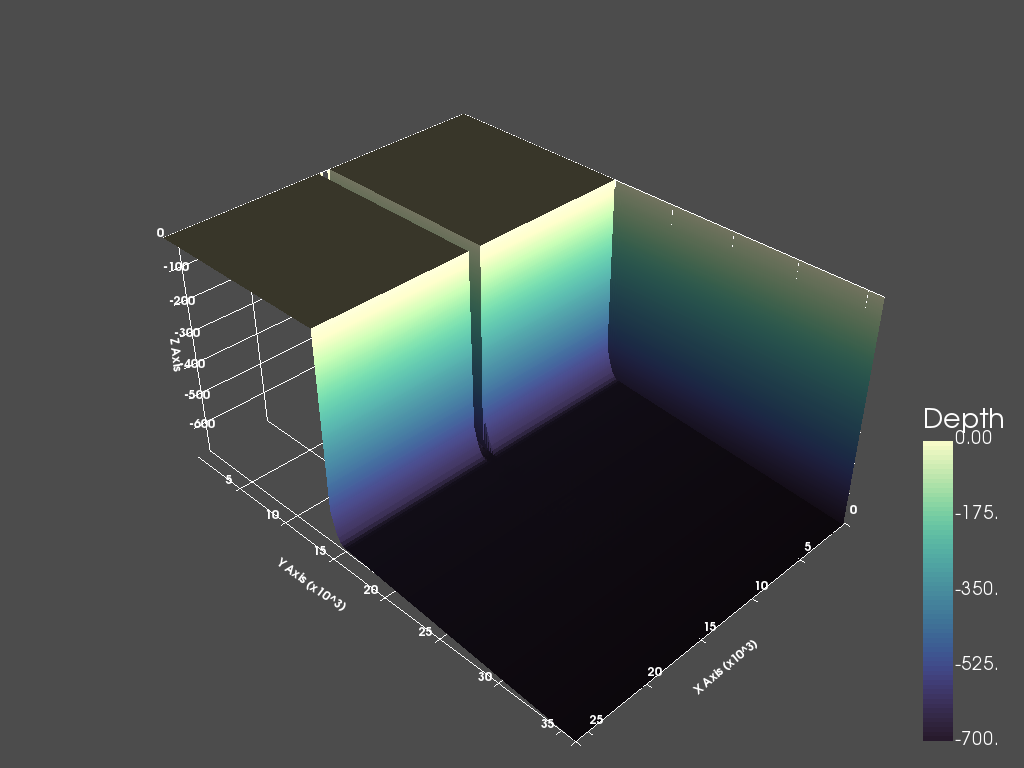

In [20]:
# Bottom surface at start
sargs = dict(height=0.25, vertical=True, position_x=0.05, position_y=0.05)

bottom_surface_scalar_args = {'vertical': True} #, 'annotation':{-350: "[m]"}}

bottom_surface_start = makeBottomSurface(trim, timestep=0) 
p = pv.Plotter()
p.add_mesh(bottom_surface_start, show_edges=False, cmap=deep_r, scalar_bar_args=bottom_surface_scalar_args)
p.show_grid()
p.set_scale(zscale=25)
p.show(screenshot="output_material/depth_sans_enc.png")

In [21]:
bottom_surface = makeBottomSurface(trim, timestep=0)

In [22]:
p = pv.Plotter(notebook=False)
p.add_mesh(bottom_surface, show_edges=False, cmap=deep)
p.show_grid()
p.set_scale(zscale=25)
p.show()

[(66236.15355765728, 71336.15355765728, 1779.4891110562912),
 (13000.0, 18100.0, -349.95703125),
 (0.0, 0.0, 1.0)]

# 3D StructuredGrid

### Depth Centers

In [23]:
depth_centers_grid = makeStructuredGridDepth(trim, keyword='SIG_LYR')

'depth' DataArray already found in DataSet!
xyz_layers.shape (1921920, 3)


In [24]:
depth_centers_grid

StructuredGrid,Information
N Cells,1873169
N Points,1921920
X Bounds,"0.000e+00, 2.620e+04"
Y Bounds,"1.000e+02, 3.640e+04"
Z Bounds,"-6.998e+02, 0.000e+00"
Dimensions,"80, 182, 132"
N Arrays,0


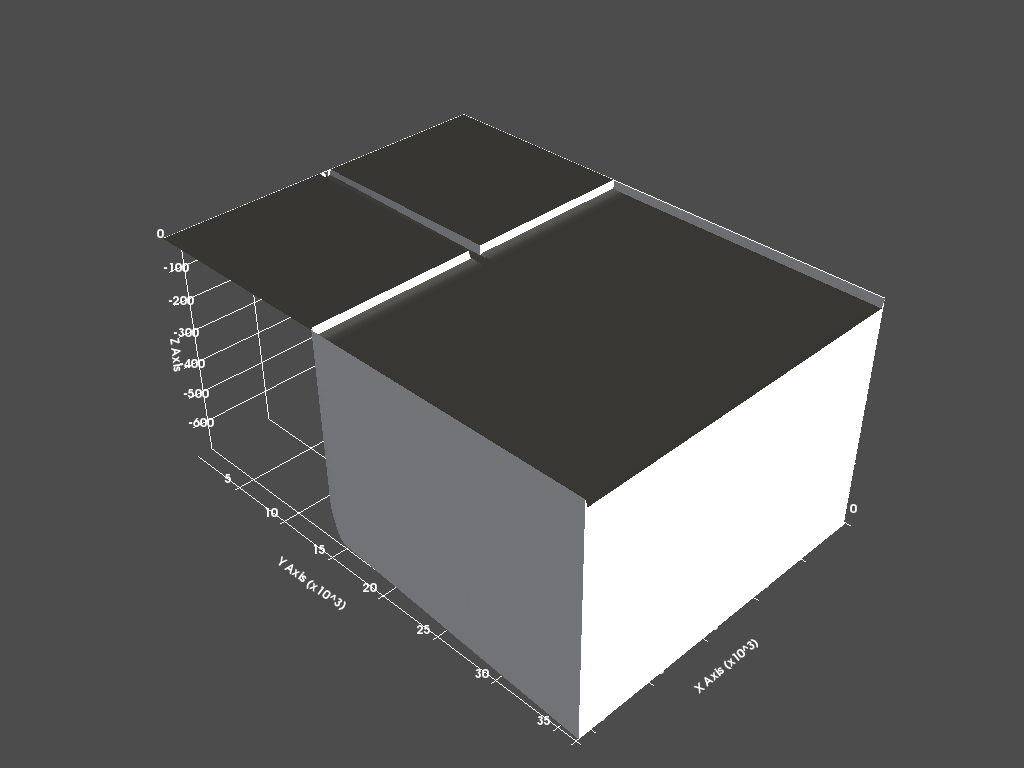

In [25]:
# Sanity check of centers grid
p = pv.Plotter()
p.add_mesh(depth_centers_grid)
# p.add_mesh(depth_centers_grid.points, point_size=0.01, color="black")
p.show_grid()
p.set_scale(zscale=25)
p.show()

### Depth Interfaces

In [26]:
depth_interfaces_grid = makeStructuredGridDepth(trim, keyword='SIG_INTF')

'depth' DataArray already found in DataSet!
xyz_layers.shape (1945944, 3)


In [27]:
depth_interfaces_grid

StructuredGrid,Information
N Cells,1896880
N Points,1945944
X Bounds,"0.000e+00, 2.620e+04"
Y Bounds,"1.000e+02, 3.640e+04"
Z Bounds,"-6.999e+02, 0.000e+00"
Dimensions,"81, 182, 132"
N Arrays,0


In [28]:
# hmm_wireframe = depth_interfaces_grid.wireframe()

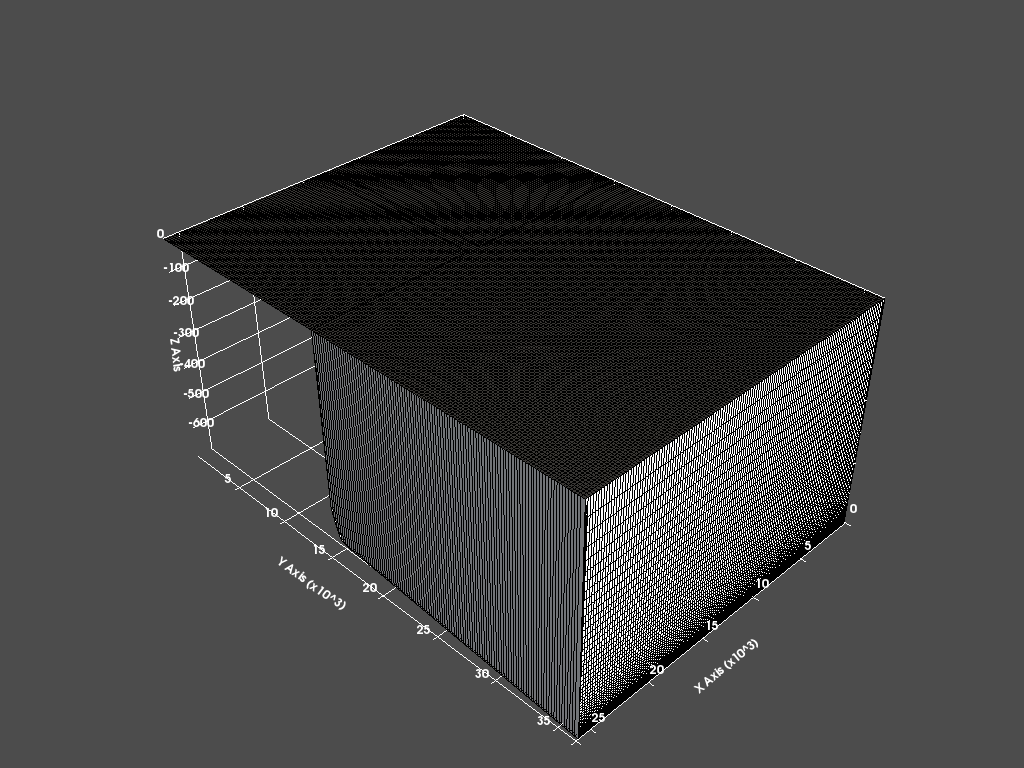

In [29]:
# Sanity check of interfaces grid
p = pv.Plotter()
p.add_mesh(depth_interfaces_grid, show_edges=True)
# p.add_mesh(depth_interfaces_grid.points, point_size=0.5, render_points_as_spheres=True) # show_edges=True,
p.show_grid()
# p.camera_position = [-5, 5, 3]
p.set_scale(zscale=25)
p.show()

## Process values at layer centres for nice plots

In [30]:
selected_outputstep = 3
time_outputstep = trim.time.isel(time=selected_outputstep).values
md(f"# Selected time is {easyTimeFormat(time_outputstep)}")

2020-02-01T22:06:00.000000000


# Selected time is Day 02/01/20 — 22:06:00

In [31]:
# print(density.isel(time=selected_outputstep).values.ravel().size)
# print(density.isel(time=selected_outputstep).values.max())

In [32]:
# # TODO FINISH function that uses keyword in trim to add to pyvista object
# def addScalarsToCentersMesh(keyword="RHO", outputstep=-10):
#     scalars = trim[keyword].transpose('time', 'M', 'N', 'KMAXOUT_RESTR')
#     scalars_at_time = scalars.isel(time=outputstep)
    
#     depth_centers_grid[keyword] = scalars_at_time

In [33]:
# addScalarsToCentersMesh("RHO", outputstep=selected_outputstep)

In [34]:
depth_centers_grid["Density"] = density.isel(time=selected_outputstep).values.ravel()
depth_centers_grid

StructuredGrid (0x151a0bc20)
  N Cells:	1873169
  N Points:	1921920
  X Bounds:	0.000e+00, 2.620e+04
  Y Bounds:	1.000e+02, 3.640e+04
  Z Bounds:	-6.998e+02, 0.000e+00
  Dimensions:	80, 182, 132
  N Arrays:	1

In [35]:
# # slices = mesh.slice_orthogonal(x=20, y=20, z=30)
# slices = depth_centers_grid.slice_along_axis(n=50, axis="y")
# # help(depth_centers_grid.slice_along_axis)
# slices.plot(cmap='viridis')

In [36]:
# clipped = depth_centers_grid.clip('y', invert=True)

In [37]:
density_threshold_lim = [1025.25, 1040]

In [38]:
threshed_density_centers = depth_centers_grid.threshold(density_threshold_lim, scalars="Density")
threshed_density_centers

UnstructuredGrid (0x12ebb21a0)
  N Cells:	44142
  N Points:	50456
  X Bounds:	8.600e+03, 1.780e+04
  Y Bounds:	3.500e+03, 2.410e+04
  Z Bounds:	-6.579e+02, -3.738e+02
  N Arrays:	1

In [39]:
density_slices_y = threshed_density_centers.slice_along_axis(n=30, axis="y")
density_slices_x = threshed_density_centers.slice_along_axis(n=6, axis="x")

In [40]:
depth_centers_grid["Velocity"] = velocity.isel(time=selected_outputstep).values.ravel()
depth_centers_grid

StructuredGrid (0x151a0bc20)
  N Cells:	1873169
  N Points:	1921920
  X Bounds:	0.000e+00, 2.620e+04
  Y Bounds:	1.000e+02, 3.640e+04
  Z Bounds:	-6.998e+02, 0.000e+00
  Dimensions:	80, 182, 132
  N Arrays:	2

In [41]:
velocity_threshold = [0.5, 2]
threshed_velocity_centers = depth_centers_grid.threshold(velocity_threshold, scalars="Velocity")
threshed_velocity_centers

UnstructuredGrid (0x12ebc5520)
  N Cells:	31987
  N Points:	37827
  X Bounds:	8.600e+03, 1.760e+04
  Y Bounds:	6.500e+03, 2.410e+04
  Z Bounds:	-6.553e+02, -4.376e+02
  N Arrays:	2

In [42]:
velocity_slices_y = threshed_velocity_centers.slice_along_axis(n=30, axis="y")
velocity_slices_x = threshed_velocity_centers.slice_along_axis(n=6, axis="x")

In [43]:
centers_outline = depth_centers_grid.outline()

### Thresholded velocity

In [47]:
p = pv.Plotter(notebook=False)
p.add_mesh(threshed_velocity_centers, scalars='Velocity', opacity=0.5, lighting=False, clim=velocity_threshold, cmap='inferno')#, scalar_bar_args=sargs)
p.add_mesh(threshed_velocity_centers.cell_centers(), point_size=0.25, color='black')
p.add_text("Velocity at {}".format(easyTimeFormat(time_outputstep)), position='upper_left')
# p.add_mesh(centers_outline, color="w")
# p.add_mesh(bottom_surface, cmap=deep, interpolate_before_map=False)
p.enable_depth_peeling(10)
p.show_grid()
p.set_scale(zscale=35)
p.show(cpos="yz", screenshot="output_material/velocity_sideview.png")  #screenshot='densitystructuredgrid.png') cpos=[1, -1, 1

2020-02-01T22:06:00.000000000


[(19968.743629069162, 12699.655212400286, -491.0650990012874),
 (15142.16447032585, 14702.928256664716, -580.0565654085624),
 (-0.5837900476278077, -0.17328495840778818, 0.7931970142911112)]

### Thresholded density

2020-02-01T22:06:00.000000000
Finished exporting dataset to:  /Users/julesblom/ThesisPython/output_material/testdensityscene.vtkjs


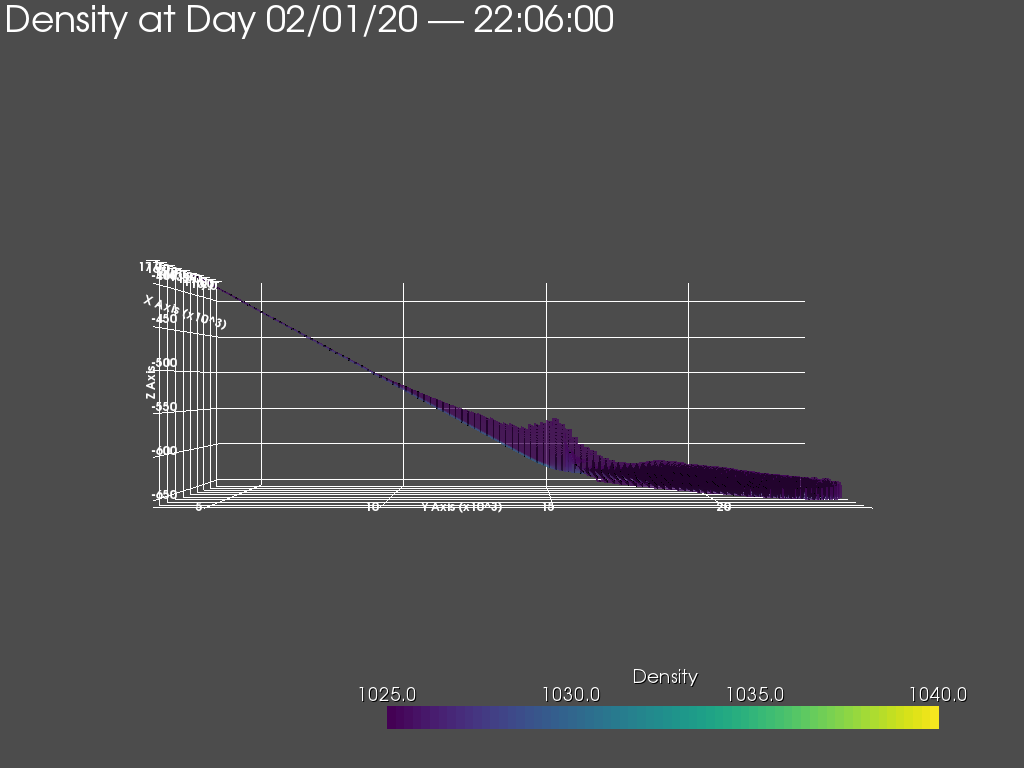

In [48]:
density_scalar_bar_args = dict(fmt="%.1f", shadow=True, n_labels=4)

p = pv.Plotter() 
p.add_mesh(threshed_density_centers, scalars='Density', opacity=0.5, lighting=False, clim=(1025, 1040), scalar_bar_args=density_scalar_bar_args)
p.add_mesh(threshed_density_centers.cell_centers(), point_size=0.5, color='black')
# p.add_mesh(centers_outline, color="w")
# p.add_mesh(bottom_surface, cmap=deep, interpolate_before_map=False)
p.enable_depth_peeling(10)
p.add_text("Density at {}".format(easyTimeFormat(time_outputstep)), position='upper_left')
p.show_grid()
p.set_scale(zscale=25)
p.export_vtkjs("output_material/testdensityscene")
p.show(cpos="yz", screenshot="output_material/density_sideview.png")

### Velocity slices

In [59]:
slices_cpos = [(11399.311231215506, 34346.57001170183, -322.0071766973835),
 (13110.110188633109, 19879.751919928676, -652.7365794850148),
 (0.08542950349183036, -0.48675765354388767, 0.8693496342954244)]

In [50]:
min_velo, max_velo = [0.1, 2.5]

2020-02-01T22:06:00.000000000


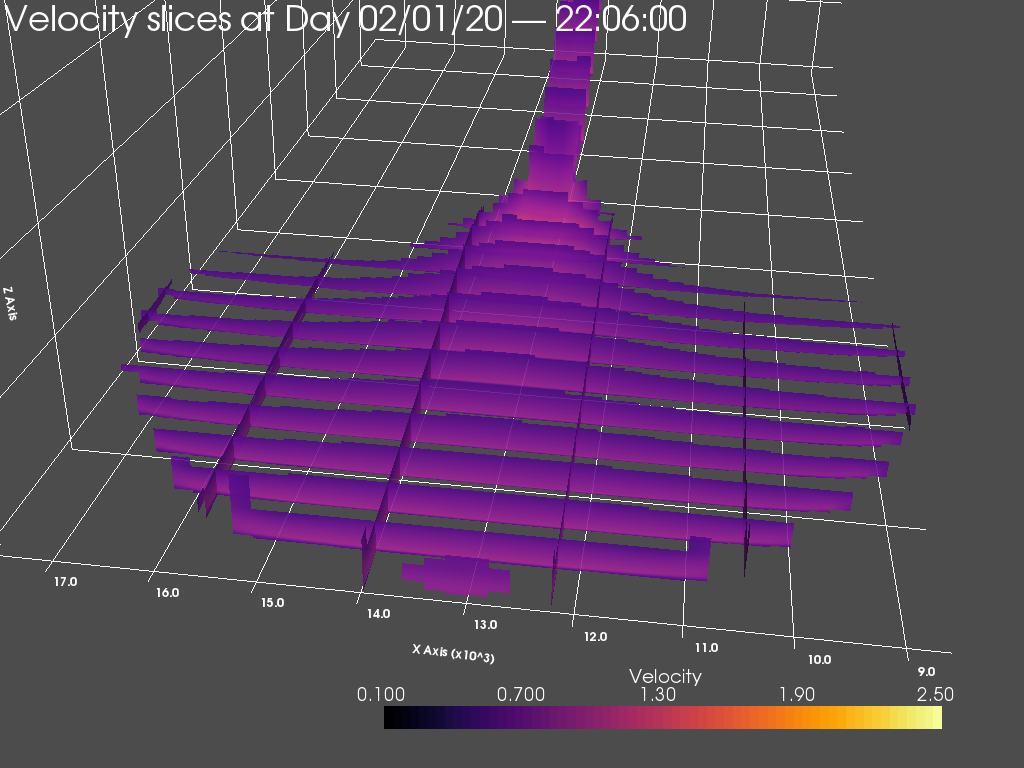

In [60]:
p = pv.Plotter(notebook=True)
p.add_mesh(velocity_slices_x, scalars='Velocity', cmap="inferno", opacity=0.9, clim=[min_velo, max_velo], ambient=0.3)
p.add_mesh(velocity_slices_y, scalars='Velocity', cmap="inferno", opacity=0.9, clim=[min_velo, max_velo], ambient=0.3)
p.enable_depth_peeling(10)
p.add_text(f"Velocity slices at {easyTimeFormat(time_outputstep)}", position='upper_left')
p.show_grid()
p.set_scale(zscale=25)
# p.show(cpos="xz",  auto_close=False, use_panel=True) #screenshot="density_slices.png") # screenshot='densitystructuredgrid.png') cpos=[1, -1, 1
p.show(cpos=slices_cpos, screenshot="output_material/velocity_height.png")

### Density slices

2020-02-01T22:06:00.000000000


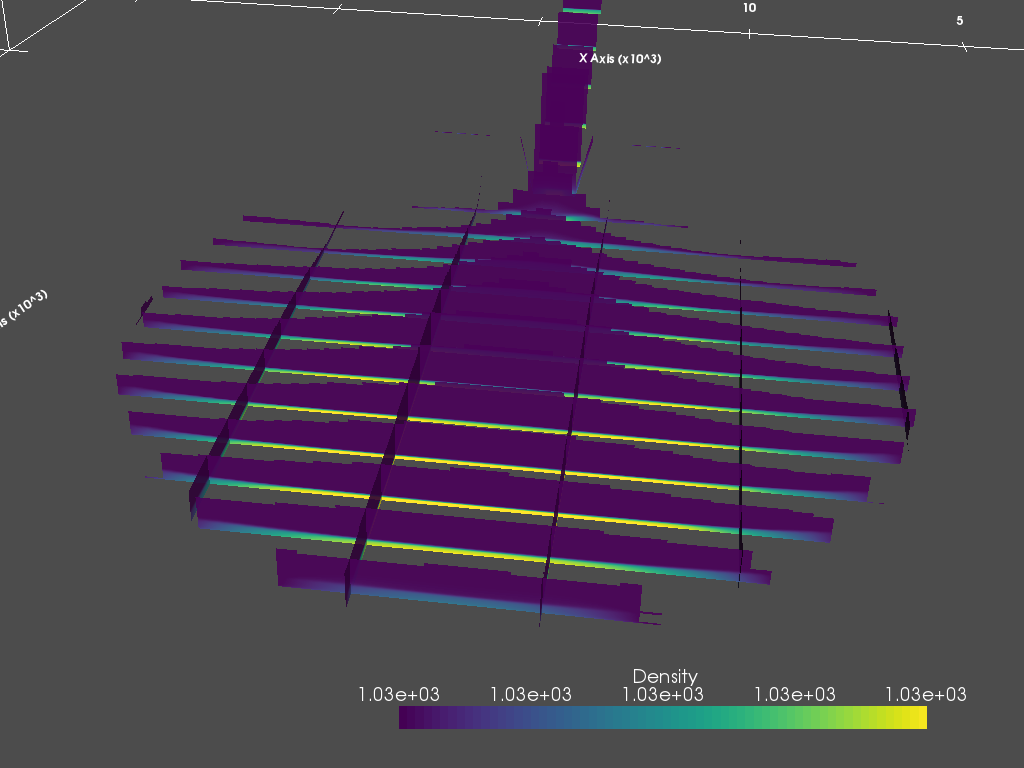

In [61]:
density_slices_p = pv.Plotter(notebook=True)
density_slices_p.add_mesh(density_slices_x, scalars='Density', cmap="viridis", opacity=0.9, clim=[1025.5, 1030])
density_slices_p.add_mesh(density_slices_y, scalars='Density', cmap="viridis", opacity=0.9, clim=[1025.5, 1030])
density_slices_p.enable_depth_peeling(10)
density_slices_p.add_mesh(centers_outline, color="w")
p.add_text(f"Density slices slices at {easyTimeFormat(time_outputstep)}", position='upper_left')
density_slices_p.show_grid()
density_slices_p.set_scale(zscale=25)
# p.show(cpos="xz",  auto_close=False, use_panel=True) #screenshot="density_slices.png") # screenshot='densitystructuredgrid.png') cpos=[1, -1, 1
density_slices_p.show(cpos=slices_cpos, screenshot="output_material/density_height.png")

In [53]:
trim.time[6].values

numpy.datetime64('2020-02-02T03:12:00.000000000')

## Widgets/Side slice

In [47]:
slice_widget_p = pv.Plotter(notebook=False)
slice_widget_p.add_mesh(bottom_surface, cmap=deep)
# slice_widget_p.add_mesh_clip_plane(depth_centers_grid, scalars="Velocity",cmap="inferno")
# slice_widget_p.add_mesh_slice(depth_centers_grid, scalars="Velocity", cmap="inferno")
slice_widget_p.add_mesh_isovalue(depth_centers_grid, scalars="Velocity",cmap="inferno", lighting=True, ambient=0.2)
slice_widget_p.set_scale(zscale=25)
slice_widget_p.show()

[(37639.645445788556, 29648.38960174936, -237.9936951947317),
 (25333.66438310587, 24482.10161149483, -378.72682741225196),
 (-0.43282748838914453, 0.5387724326699233, 0.7227618079904873)]

In [64]:
i_slice_plotter = pv.Plotter(notebook=False)
i_slice_plotter.add_mesh_slice_orthogonal(depth_centers_grid, scalars="Velocity", cmap="inferno", pl)
i_slice_plotter.set_scale(zscale=25)
i_slice_plotter.show()

[(76921.40654737451, 59783.59557845184, 687.2131936872247),
 (13100.000244140625, 18250.0, -349.90234375),
 (-0.2762732336296048, -0.1663800232811195, 0.946567899430789)]

In [ ]:
# slices = depth_centers_grid.isel(N=slice(49,60,4))

In [ ]:
# depth_centers_grid.slice_along_line()

In [ ]:
# clim = depth_centers_grid.get_data_range('density')
# clim

In [ ]:
density_slices_clim = (1025, 1026)

In [ ]:
single_slice = depth_centers_grid.slice(normal=[1, 0, 0])

In [ ]:
z_min, z_max = depth_centers_grid.bounds[-2:]
print(z_min, z_max)

In [ ]:
threshed_density_centers = depth_centers_grid.threshold([1025.1, 1028], scalars="Density")
threshed_density_centers

In [ ]:
bounds =  (0, 18000, 500, 20000, -150, z_max)
cross_slices = depth_centers_grid.slice_along_axis(n=9, axis='y', bounds=bounds)
# cross_slices = depth_centers_grid.slice_along_axis(n=2, bounds=bounds, axis='y')

In [ ]:
slice_plotter = pv.Plotter(notebook=True)
slice_plotter.add_mesh(bottom_surface, cmap=deep)
slice_plotter.add_mesh(threshed_density_centers, scalars='Density', opacity=0.5, lighting=False, clim=clim)#, scalar_bar_args=sargs)
slice_plotter.add_mesh(threshed_density_centers.cell_centers(), point_size=0.5, color='black')                       
slice_plotter.enable_depth_peeling(10)
slice_plotter.add_mesh(cross_slices, scalars='Density', clim=density_slices_clim)
# slice_plotter.add_mesh(single_slice, scalars='density', clim=clim)#, show_edges=True)
slice_plotter.show_grid()
slice_plotter.set_scale(zscale=25)
slice_plotter.show(cpos='yz')

# Concentrations

In [77]:
# concentration_sand = concentration.isel(LSTSCI=0)
concentration_silt = concentration.isel(LSTSCI=1)
concentration_silt = concentration_silt.assign_attrs({'long_name': 'Silt concentrations percentage per layer in zeta point',
                                                      'units': '%',
                                                      'grid': 'grid',
                                                      'location': 'face'})

In [78]:
depth_centers_grid["silt_conc"] = concentration_silt.isel(time=selected_outputstep).values.ravel()
depth_centers_grid

StructuredGrid (0x13234b440)
  N Cells:	1873169
  N Points:	1921920
  X Bounds:	0.000e+00, 2.620e+04
  Y Bounds:	1.000e+02, 3.640e+04
  Z Bounds:	-6.998e+02, 0.000e+00
  Dimensions:	80, 182, 132
  N Arrays:	3

In [79]:
silt_conc_threshold_lim = [0.5, 3]
threshed_silt_conc = depth_centers_grid.threshold(silt_conc_threshold_lim, scalars="silt_conc")
threshed_silt_conc

UnstructuredGrid (0x13345a6e0)
  N Cells:	33098
  N Points:	39345
  X Bounds:	5.600e+03, 2.060e+04
  Y Bounds:	8.700e+03, 2.970e+04
  Z Bounds:	-6.774e+02, -4.876e+02
  N Arrays:	3

In [80]:
conc_silt_clim = (0.5, 4)
silt_cpos = [(-30474.953652860255, 66185.25362410465, 751.2731784041288),
             (10100.0, 16300.0, -504.2824249267578),
             (0.34247803441190433, -0.2847957891478262, 0.8953212576662222)]

In [81]:
p = pv.Plotter(notebook=False) 
p.add_mesh(threshed_silt_conc, colormap='plasma', scalars='silt_conc', opacity=0.5, lighting=False, clim=conc_silt_clim)#, scalar_bar_args=sargs)
# p.add_mesh(threshed_silt_conc.cell_centers(), point_size=0.5, color='black')
# p.add_mesh(centers_outline, color="w")
# p.add_mesh(bottom_surface, cmap=deep, interpolate_before_map=False)
p.enable_depth_peeling(10)
p.add_text(f"Silt concentration at {easyTimeFormat(time_outputstep)}", position='upper_left')
p.show_grid()
p.set_scale(zscale=25)
p.show(cpos='silt_cpos', screenshot="output_material/silt_conc_sideview.png")

2020-02-07T17:30:00.000000000


[(9389.26210714944, 19272.55085913588, -1686.098706089363),
 (13779.529630373892, 21691.529486557163, -607.6309939133579),
 (0.98704970854002, -0.024592922222572124, -0.15851833032055299)]

## Silt concentration contour

In [ ]:
silt_conc_contours = threshed_silt_conc.contour()
silt_conc_contours

In [ ]:
p = pv.Plotter(notebook=False) 
p.add_mesh(silt_conc_contours, scalars='silt_conc', opacity=0.5, lighting=False, clim=conc_silt_clim)#, scalar_bar_args=sargs)
# p.add_mesh(threshed_silt_conc.cell_centers(), point_size=0.5, color='black')
# p.add_mesh(centers_outline, color="w")
# p.add_mesh(bottom_surface, cmap=deep, interpolate_before_map=False)
p.enable_depth_peeling(10)
p.add_text(f"Silt concentration contour at {easyTimeFormat(time_outputstep))}", position='upper_left')
p.show_grid()
p.set_scale(zscale=25)
p.show(cpos=slit_cpos)

In [ ]:
# select_outputstep_widget = pn.widgets.IntSlider(start=0, end=trim.time.size, value=5, name="Outputstep")

# Animation

In [1]:
time_lims = (1, trim.time.size-1)
time_lims

NameError: name 'trim' is not defined

# Update grid with time?

In [135]:
# https://docs.pyvista.org/examples/02-plot/gif.html#sphx-glr-examples-02-plot-gif-py
# Create a plotter object and set the scalars to the Z height
anim_plotter = pv.Plotter()

sargs = dict(
    title_font_size=20,
    label_font_size=16,
    shadow=True,
    n_labels=5,
    fmt="%.1f",
    font_family="arial",
)


# anim_plotter.add_mesh(bottom_surface, cmap=deep) #, scalars=trim.bottom_stress.isel(time=0).values[:-1,:-1].T,
                  #  interpolate_before_map=False, scalar_bar_args=sargs, stitle='Bottom Stress N/m2')
anim_plotter.set_scale(zscale=25)
anim_plotter.add_mesh(centers_outline) #, scalars=trim.bottom_stress.isel(time=0).values[:-1,:-1].T,
anim_plotter.enable_depth_peeling(10)
anim_plotter.show_grid()

(vtkRenderingAnnotationPython.vtkCubeAxesActor)0x20c189590

In [136]:
trim.time.size

11

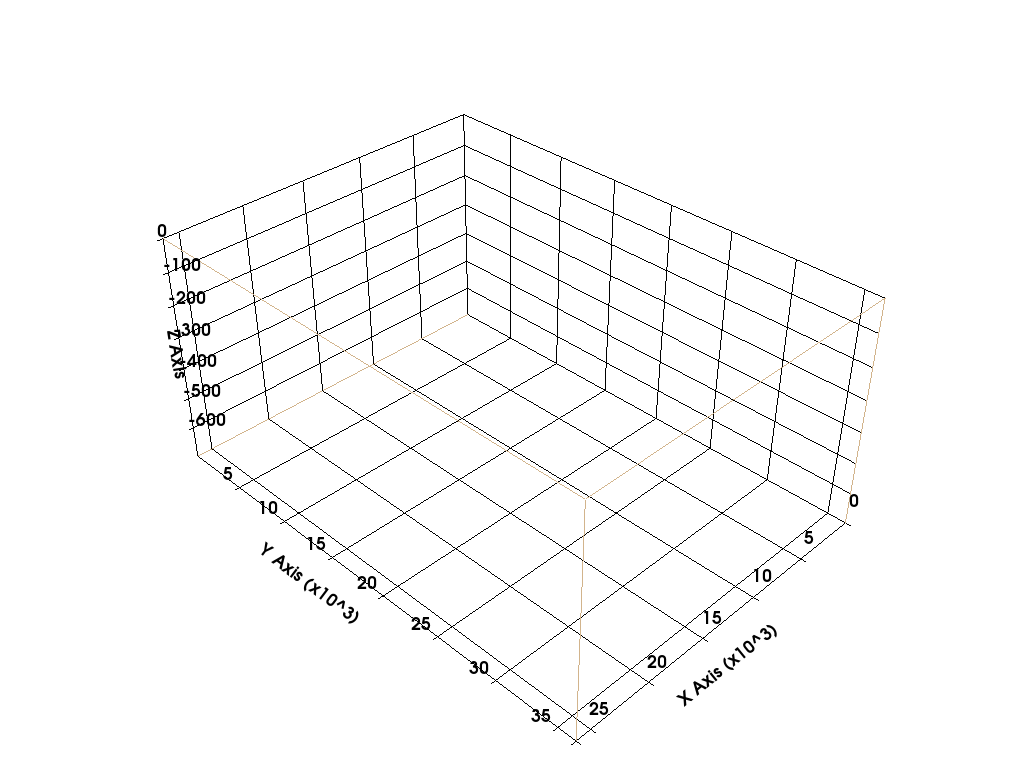

outputstep 2 1041.263
2020-02-01T20:24:00.000000000
outputstep 3 1031.8147
2020-02-01T22:06:00.000000000
outputstep 4 1028.8896
2020-02-01T23:48:00.000000000
outputstep 5 1026.6266
2020-02-02T01:30:00.000000000
outputstep 6 1025.8
2020-02-02T03:12:00.000000000


In [137]:
anim_plotter.show(auto_close=False)

# anim_plotter.open_gif("velocity_grid_animation.gif") # Open a gif
anim_plotter.open_movie("output_material/density_grid_animation.mp4")

# pts = grid.points.copy()

for i in range(2, trim.time.size-4, 1):
    new_density = density.isel(time=i).values.ravel()
#     new_velocity = velocity.isel(time=i).values.ravel()
#     new_bottom_stress = trim.bottom_stress.isel(time=i).values[:-1,:-1].ravel(order="F") 
    threshold_lims = [1025.5, 1035]
    print("outputstep", i, new_density.max())
#     bottom_surface.point_arrays["Bottom Stress N/m2"] = new_bottom_stress
    depth_centers_grid["density"] = new_density
#     depth_centers_grid["velocity"] = new_velocity
    
    new_threshed_density_centers = depth_centers_grid.threshold(threshold_lims, scalars="density")
#     new_threshed_velocity_centers = depth_centers_grid.threshold([0.1, 1], scalars="velocity")
    
    # Check if object doesnot have zero cells!
    timestring = easyTimeFormat(trim.time.isel(time=i).values)
    timetext = anim_plotter.add_text(f"Density at {timestring}", position='upper_left')
    density_vtk_obj = anim_plotter.add_mesh(new_threshed_density_centers, clim=threshold_lims, cmap='viridis', opacity=0.6, scalar_bar_args=sargs, lighting=True)
#     velocity_vtk_obj = anim_plotter.add_mesh(new_threshed_velocity_centers, clim=[0.1, 1], cmap="inferno", opacity=0.5, scalar_bar_args=sargs, lighting=True)
    
    anim_plotter.write_frame()
    anim_plotter.write_frame()
    anim_plotter.write_frame()

    anim_plotter.remove_actor(timetext)
    anim_plotter.remove_actor(density_vtk_obj) #velocity_vtk_obj
    
# Close movie and delete object
anim_plotter.close()